In [1]:
%matplotlib inline

# 4 - Dynamic Connectivity (Group Analysis)

In this short tutorial, we will build and expand on the previous tutorials by computing the dynamic connectivity, using Time-Varying Functional Connectivity Graphs.

In the near future, the standard method of "sliding window" will be supported.

- - -

### Load data

In [2]:
import numpy as np

In [3]:
raw_eeg_eyes_open = np.load("data/eyes_opened.npy")
raw_eeg_eyes_closed = np.load("data/eyes_closed.npy")

num_trials, num_channels, num_samples = np.shape(raw_eeg_eyes_open)

read_trials = 10

In [4]:
eeg_eyes_open = raw_eeg_eyes_open[0:read_trials, ...]
eeg_eyes_closed = raw_eeg_eyes_closed[0:read_trials, ...]

### Dynamic connectivity

#### Prepare and configure the estimator object

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from dyfunconn import tvfcg
from dyfunconn.fc import IPLV

In [6]:
fb = [7.0, 13.0]
cc = 4.0
fs = 160.0
step = 80

In [7]:
estimator = IPLV(fb, fs)

#### Process condition "eyes open" 

In [8]:
print('Working .', end='')

X = np.squeeze(eeg_eyes_open[0])
fcgs = tvfcg(X, estimator, fb, fs, cc, step)

fcgs_eyes_open = np.array(np.real(fcgs))

for i in range(1, read_trials):
    print('.', end='')
    
    X = np.squeeze(eeg_eyes_open[i])
    fcgs = tvfcg(X, estimator, fb, fs, cc, step)
        
    fcgs_eyes_open = np.vstack([fcgs_eyes_open, np.real(fcgs)])
    
print('')

Working ..........


#### Process condition "eyes closed"

In [9]:
print('Working .', end='')

X = np.squeeze(eeg_eyes_closed[0])
fcgs = tvfcg(X, estimator, fb, fs, cc, step)

fcgs_eyes_closed = np.array(np.real(fcgs))

for i in range(1, read_trials):
    print('.', end='')

    X = np.squeeze(eeg_eyes_closed[i])
    fcgs = tvfcg(X, estimator, fb, fs, cc, step)
        
    fcgs_eyes_closed = np.vstack([fcgs_eyes_closed, np.real(fcgs)])
    
print('')

Working ..........


### FCμstates / Clustering

In [10]:
from dyfunconn.cluster import NeuralGas

In [11]:
num_fcgs_eo, _, _ = np.shape(fcgs_eyes_open)
num_fcgs_ec, _, _ = np.shape(fcgs_eyes_closed)

In [12]:
fcgs = np.vstack([fcgs_eyes_open, fcgs_eyes_closed])
num_fcgs, num_channels, num_channels = np.shape(fcgs)

triu_ind = np.triu_indices_from(np.squeeze(fcgs[0, ...]), k=1)

fcgs = fcgs[:, triu_ind[0], triu_ind[1]]

In [50]:
rng = np.random.RandomState(0)

mdl = NeuralGas(n_protos=5, rng=rng).fit(fcgs)
encoding, symbols = mdl.encode(fcgs)

#### Separate the encoded symbols based on their original groupings

In [51]:
grp_dist_eo = symbols[0:num_fcgs_eo]
grp_dist_ec = symbols[num_fcgs_eo:]

### Plot

In [52]:
h_grp_dist_eo = np.histogram(grp_dist_eo, bins=mdl.n_protos, normed=True)
h_grp_dist_ec = np.histogram(grp_dist_ec, bins=mdl.n_protos, normed=True)

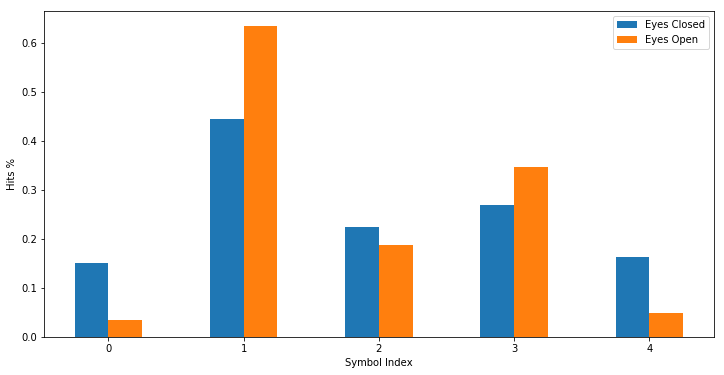

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

ind = np.arange(mdl.n_protos)
p1 = ax.bar(ind - 0.125, h_grp_dist_ec[0], 0.25, label='Eyes Closed')
p2 = ax.bar(ind + 0.125, h_grp_dist_eo[0], 0.25, label='Eyes Open')

ax.legend()
ax.set_xlabel('Symbol Index')
ax.set_ylabel('Hits %')
ax.set_xticks(np.arange(mdl.n_protos))
plt.show()

Convert state prototypes to symmetric matrices and plot them

In [54]:
protos_mtx = np.zeros((mdl.n_protos, 64, 64))

for i in range(mdl.n_protos):
    symbol_state = np.zeros((64, 64))
    symbol_state[triu_ind] = mdl.protos[i, :]
    symbol_state = symbol_state + symbol_state.T
    np.fill_diagonal(symbol_state, 1.0)
    
    protos_mtx[i, :, :] = symbol_state

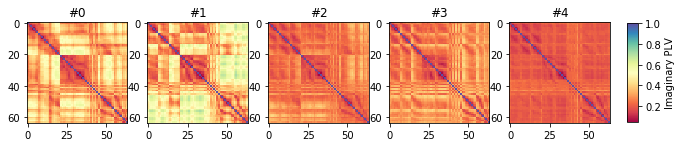

In [58]:
mtx_min = np.min(protos_mtx)
mtx_max = np.max(protos_mtx)

f, ax = plt.subplots(ncols=mdl.n_protos, figsize=(12, 12))
for i in range(mdl.n_protos):
    cax = ax[i].imshow(np.squeeze(protos_mtx[i,...]), vmin=mtx_min, vmax=mtx_max, cmap=plt.cm.Spectral)
    ax[i].set_title('#{0}'.format(i))

# move the colorbar to the side ;)
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.82, 0.445, 0.0125, 0.115])
cb = f.colorbar(cax, cax=cbar_ax)
cb.set_label('Imaginary PLV')

#### Separate symbols per subject

Now we would like to analyze the symbols per subject, per group.


In [61]:
grp_sym_eo = np.array_split(grp_dist_eo, 10, axis=0)
grp_sym_ec = np.array_split(grp_dist_ec, 10, axis=0)

In [62]:
subj1_eyes_open = grp_sym_eo[0]
subj1_eyes_closed = grp_sym_ec[0]

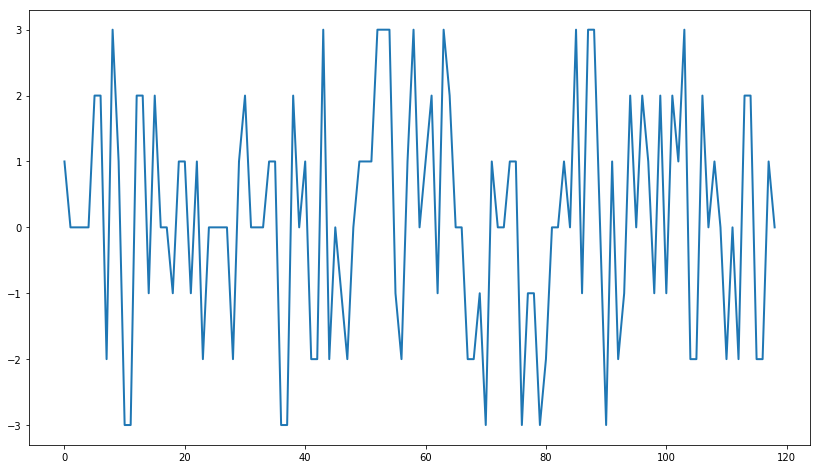

In [78]:
plt.figure(figsize=(14, 8))
_ = plt.plot(eyes_open - eyes_closed, lw=2.0)